## Imports & load

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from glob import glob

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

# load cleaned parquet (con gmm20_cluster)
df = pd.read_parquet("bike_data_clean.parquet")
df['start_date'] = pd.to_datetime(df['start_date'])
df['timestamp'] = pd.to_datetime(df['start_date']) + pd.to_timedelta(df['start_hour'], unit='h')
print("Loaded df shape:", df.shape)
df.head()


Loaded df shape: (17531179, 23)


,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year,gender,...,start_minute,stop_date,stop_hour,stop_minute,start_weekday,start_month,start_year,gmm20_cluster,end_gmm20_cluster,timestamp
0,196,315,40.703552,-74.006699,259,40.701221,-74.012344,18534,1997,1,...,1,2018-01-01,0,5,0,1,2018,15,15,2018-01-01
1,207,3224,40.739975,-74.005142,470,40.743454,-74.000038,19651,1978,1,...,2,2018-01-01,0,6,0,1,2018,3,3,2018-01-01
2,613,386,40.714947,-74.002342,2008,40.705692,-74.016777,21678,1982,1,...,3,2018-01-01,0,13,0,1,2018,15,15,2018-01-01
3,402,438,40.727791,-73.985649,380,40.734013,-74.002937,30722,1989,1,...,6,2018-01-01,0,13,0,1,2018,8,3,2018-01-01
4,375,466,40.743954,-73.991447,325,40.736244,-73.984741,29822,1982,1,...,6,2018-01-01,0,12,0,1,2018,13,13,2018-01-01


##  Aggregate to cluster-hour and build features

In [3]:

# Aggregate pickups per cluster-hour
agg = df.groupby(['gmm20_cluster','timestamp']).size().reset_index(name='pickups')

# build full hourly index per cluster (fill missing hours with 0)
frames = []
for c in agg['gmm20_cluster'].unique():
    tmp = agg[agg['gmm20_cluster']==c].set_index('timestamp').resample('H').asfreq()
    # create pickups series aligned to full index (fill missing with 0)
    s = agg[agg['gmm20_cluster']==c].set_index('timestamp')['pickups'].reindex(tmp.index, fill_value=0)
    tmp = tmp.assign(pickups = s.values)
    tmp = tmp.reset_index().assign(gmm20_cluster=c)
    frames.append(tmp)
ts = pd.concat(frames, ignore_index=True)
ts = ts.rename(columns={'timestamp':'timestamp'})[['gmm20_cluster','timestamp','pickups']]

# create lags and rolling features
def make_lags_rolls(df_in, lags=[1,24,168]):
    df = df_in.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df.groupby('gmm20_cluster')['pickups'].shift(lag)
    df['rmean_3h'] = df.groupby('gmm20_cluster')['pickups'].shift(1).rolling(3).mean().reset_index(level=0, drop=True)
    df['rmean_24h'] = df.groupby('gmm20_cluster')['pickups'].shift(1).rolling(24).mean().reset_index(level=0, drop=True)
    return df

ts = make_lags_rolls(ts, lags=[1,24,168])
# calendar
ts['hour'] = ts['timestamp'].dt.hour.astype('int8')
ts['weekday'] = ts['timestamp'].dt.weekday.astype('int8')
ts['month'] = ts['timestamp'].dt.month.astype('int8')

# drop initial NaNs created by lags
ts = ts.dropna().reset_index(drop=True)

# target
ts['y'] = ts['pickups'].astype(float)


# DROP-OFFS (ARRIVALS) — time series per cluster-hour


# Aggregate dropoffs per cluster-hour using end_gmm20_cluster
agg_drop = df.groupby(['end_gmm20_cluster', 'timestamp']).size().reset_index(name='dropoffs')

frames_drop = []
for c in agg_drop['end_gmm20_cluster'].unique():
    tmp = agg_drop[agg_drop['end_gmm20_cluster'] == c].set_index('timestamp').resample('H').asfreq()
    s = agg_drop[agg_drop['end_gmm20_cluster'] == c].set_index('timestamp')['dropoffs'].reindex(tmp.index, fill_value=0)
    tmp = tmp.assign(dropoffs=s.values)
    tmp = tmp.reset_index().assign(gmm20_cluster=c)  # usamos mismo nombre de columna de cluster
    frames_drop.append(tmp)

ts_drop = pd.concat(frames_drop, ignore_index=True)
ts_drop = ts_drop[['gmm20_cluster', 'timestamp', 'dropoffs']]

# Función de lags y medias móviles para dropoffs
def make_lags_rolls_drop(df_in, lags=[1,24,168]):
    df = df_in.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df.groupby('gmm20_cluster')['dropoffs'].shift(lag)
    df['rmean_3h'] = df.groupby('gmm20_cluster')['dropoffs'].shift(1).rolling(3).mean().reset_index(level=0, drop=True)
    df['rmean_24h'] = df.groupby('gmm20_cluster')['dropoffs'].shift(1).rolling(24).mean().reset_index(level=0, drop=True)
    return df

ts_drop = make_lags_rolls_drop(ts_drop, lags=[1,24,168])

# calendar features
ts_drop['hour'] = ts_drop['timestamp'].dt.hour.astype('int8')
ts_drop['weekday'] = ts_drop['timestamp'].dt.weekday.astype('int8')
ts_drop['month'] = ts_drop['timestamp'].dt.month.astype('int8')

# drop NaNs from lags
ts_drop = ts_drop.dropna().reset_index(drop=True)

# target for dropoffs
ts_drop['y'] = ts_drop['dropoffs'].astype(float)

print("ts_drop shape:", ts_drop.shape)
print(ts_drop.head())

# ---- Time split: Jan–Oct for train/val, Nov–Dec for test ----

# Aseguramos que timestamp es datetime
ts['timestamp'] = pd.to_datetime(ts['timestamp'])

# TEST = NOV + DEC (lo que pide el proyecto)
test_start = pd.Timestamp('2018-11-01 00:00:00')

# Train + Val = JAN–OCT
trainval = ts[ts['timestamp'] < test_start].copy()

# Dentro de Jan–Oct: últimos 14 días = Validation
last_time_trainval = trainval['timestamp'].max()
val_start = last_time_trainval - pd.Timedelta(days=14)

train = trainval[trainval['timestamp'] < val_start].copy()
val   = trainval[(trainval['timestamp'] >= val_start) & (trainval['timestamp'] < test_start)].copy()
test  = ts[ts['timestamp'] >= test_start].copy()

print("Shapes train/val/test:", train.shape, val.shape, test.shape)
print("Train:", train['timestamp'].min(), "→", train['timestamp'].max())
print("Val:  ", val['timestamp'].min(),   "→", val['timestamp'].max())
print("Test: ", test['timestamp'].min(),  "→", test['timestamp'].max())

# -----------------------------------------------------
# Time split for DROP-OFFS (same logic: Jan–Oct / Nov–Dec)
# -----------------------------------------------------

ts_drop['timestamp'] = pd.to_datetime(ts_drop['timestamp'])

test_start_d = pd.Timestamp('2018-11-01 00:00:00')
trainval_d = ts_drop[ts_drop['timestamp'] < test_start_d].copy()

last_time_trainval_d = trainval_d['timestamp'].max()
val_start_d = last_time_trainval_d - pd.Timedelta(days=14)

train_d = trainval_d[trainval_d['timestamp'] < val_start_d].copy()
val_d   = trainval_d[(trainval_d['timestamp'] >= val_start_d) & (trainval_d['timestamp'] < test_start_d)].copy()
test_d  = ts_drop[ts_drop['timestamp'] >= test_start_d].copy()

print("Dropoffs train/val/test shapes:", train_d.shape, val_d.shape, test_d.shape)
print("Dropoffs Train:", train_d['timestamp'].min(), "→", train_d['timestamp'].max())
print("Dropoffs Val:  ", val_d['timestamp'].min(),   "→", val_d['timestamp'].max())
print("Dropoffs Test: ", test_d['timestamp'].min(),  "→", test_d['timestamp'].max())



ts_drop shape: (179985, 12)
   gmm20_cluster           timestamp  dropoffs  lag_1  lag_24  lag_168  \
0             -1 2018-01-16 18:00:00         0    0.0     0.0      1.0   
1             -1 2018-01-16 19:00:00         0    0.0     0.0      0.0   
2             -1 2018-01-16 20:00:00         0    0.0     0.0      0.0   
3             -1 2018-01-16 21:00:00         0    0.0     0.0      0.0   
4             -1 2018-01-16 22:00:00         0    0.0     0.0      0.0   

   rmean_3h  rmean_24h  hour  weekday  month    y  
0       0.0        0.0    18        1      1  0.0  
1       0.0        0.0    19        1      1  0.0  
2       0.0        0.0    20        1      1  0.0  
3       0.0        0.0    21        1      1  0.0  
4       0.0        0.0    22        1      1  0.0  
Shapes train/val/test: (135818, 12) (6740, 12) (29275, 12)
Train: 2018-01-08 00:00:00 → 2018-10-17 22:00:00
Val:   2018-10-17 23:00:00 → 2018-10-31 23:00:00
Test:  2018-11-01 00:00:00 → 2018-12-31 23:00:00
Dropoffs 

## Seasonal naive baseline (lag 168h = same weekday/hour last week)

In [4]:
for d in [ts, train, val, test]:
    d['lag_168'] = d.groupby('gmm20_cluster')['pickups'].shift(168)

# Updated metrics function (compatible with older sklearn)
def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {"MAE": mae, "RMSE": rmse}


val_b = val.dropna(subset=['lag_168']).copy()
val_b['pred_naive'] = val_b['lag_168']
print("Baseline VAL metrics:", metrics(val_b['y'].values, val_b['pred_naive'].values))

test_b = test.dropna(subset=['lag_168']).copy()
test_b['pred_naive'] = test_b['lag_168']
print("Baseline TEST metrics:", metrics(test_b['y'].values, test_b['pred_naive'].values))

# =====================================================
# Seasonal naive baseline for DROP-OFFS (lag 168h)
# =====================================================

for d in [ts_drop, train_d, val_d, test_d]:
    d['lag_168'] = d.groupby('gmm20_cluster')['dropoffs'].shift(168)

val_bd = val_d.dropna(subset=['lag_168']).copy()
val_bd['pred_naive'] = val_bd['lag_168']
print("Baseline DROP-OFFS VAL metrics:", metrics(val_bd['y'].values, val_bd['pred_naive'].values))

test_bd = test_d.dropna(subset=['lag_168']).copy()
test_bd['pred_naive'] = test_bd['lag_168']
print("Baseline DROP-OFFS TEST metrics:", metrics(test_bd['y'].values, test_bd['pred_naive'].values))


Baseline VAL metrics: {'MAE': 24.999112426035502, 'RMSE': np.float64(61.07005144448425)}
Baseline TEST metrics: {'MAE': 31.224541771174994, 'RMSE': np.float64(72.81692053809051)}
Baseline DROP-OFFS VAL metrics: {'MAE': 23.476754015215555, 'RMSE': np.float64(59.7926090776272)}
Baseline DROP-OFFS TEST metrics: {'MAE': 29.837854866207103, 'RMSE': np.float64(72.08407978085995)}


## Preprocessing and GridSearch for Ridge & Lasso

In [5]:
# Cell 4 — Preprocessing and GridSearch for Ridge & Lasso (compatible)
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
import warnings
warnings.filterwarnings("ignore")

# Defensive transformer: convert sparse -> dense if needed
class DenseTransformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        try:
            # if sparse matrix
            return X.toarray()
        except Exception:
            return X

# Feature lists (should match previous cell)
num_feats = ['lag_1','lag_24','lag_168','rmean_3h','rmean_24h']
cat_feats = ['hour','weekday','gmm20_cluster']

# Ensure no NaNs in numeric features
train[num_feats] = train[num_feats].fillna(0)
val[num_feats] = val[num_feats].fillna(0)
test[num_feats] = test[num_feats].fillna(0)

# Column transformers
num_pipe = Pipeline([('scaler', StandardScaler())])

# Build OneHotEncoder in a way that works across sklearn versions:
try:
    # newer sklearn: sparse_output parameter
    cat_enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
except TypeError:
    # older sklearn: will return sparse by default; handle in DenseTransformer
    cat_enc = OneHotEncoder(handle_unknown='ignore')

preproc = ColumnTransformer([
    ('num', num_pipe, num_feats),
    ('cat', cat_enc, cat_feats)
], remainder='drop')

# Prepare training arrays (we pass DataFrame to GridSearch - transformer will handle)
X_train = train[num_feats + cat_feats]
y_train = train['y'].values
X_val = val[num_feats + cat_feats]
y_val = val['y'].values
X_test = test[num_feats + cat_feats]
y_test = test['y'].values

# TimeSeriesSplit for CV
tscv = TimeSeriesSplit(n_splits=5)

# ---- Ridge pipeline & grid ----
ridge_pipe = Pipeline([
    ('pre', preproc),
    ('to_dense', DenseTransformer()),   # ensure dense input for model
    ('model', Ridge())
])

param_grid_ridge = {'model__alpha': [0.01, 0.1, 0.3, 1.0, 3.0, 10.0]}  # smaller grid if slow

grid_ridge = GridSearchCV(
    ridge_pipe,
    param_grid_ridge,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

print("Fitting Ridge GridSearch (may take a while)...")
grid_ridge.fit(X_train, y_train)
best_ridge = grid_ridge.best_estimator_
print("Best Ridge params:", grid_ridge.best_params_)

# ---- Lasso pipeline & grid ----
lasso_pipe = Pipeline([
    ('pre', preproc),
    ('to_dense', DenseTransformer()),
    ('model', Lasso(max_iter=5000))
])

param_grid_lasso = {'model__alpha': [0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]}  # pared down

grid_lasso = GridSearchCV(
    lasso_pipe,
    param_grid_lasso,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

print("Fitting Lasso GridSearch (may take a while)...")
grid_lasso.fit(X_train, y_train)
best_lasso = grid_lasso.best_estimator_
print("Best Lasso params:", grid_lasso.best_params_)

# =====================================================
# Ridge & Lasso for DROP-OFFS (global models)
# =====================================================

num_feats = ['lag_1','lag_24','lag_168','rmean_3h','rmean_24h']
cat_feats = ['hour','weekday','gmm20_cluster']

# Fill NaNs
train_d[num_feats] = train_d[num_feats].fillna(0)
val_d[num_feats] = val_d[num_feats].fillna(0)
test_d[num_feats] = test_d[num_feats].fillna(0)

X_train_d = train_d[num_feats + cat_feats]
y_train_d = train_d['y'].values
X_val_d   = val_d[num_feats + cat_feats]
y_val_d   = val_d['y'].values
X_test_d  = test_d[num_feats + cat_feats]
y_test_d  = test_d['y'].values

# Reuse preproc and DenseTransformer
ridge_pipe_d = Pipeline([
    ('pre', preproc),
    ('to_dense', DenseTransformer()),
    ('model', Ridge())
])

lasso_pipe_d = Pipeline([
    ('pre', preproc),
    ('to_dense', DenseTransformer()),
    ('model', Lasso(max_iter=5000))
])

param_grid_ridge_d = {'model__alpha': [0.01, 0.1, 0.3, 1.0, 3.0, 10.0]}
param_grid_lasso_d = {'model__alpha': [0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]}

tscv = TimeSeriesSplit(n_splits=5)

print("Fitting Ridge GridSearch for DROP-OFFS...")
grid_ridge_d = GridSearchCV(
    ridge_pipe_d,
    param_grid_ridge_d,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
grid_ridge_d.fit(X_train_d, y_train_d)
best_ridge_d = grid_ridge_d.best_estimator_
print("Best Ridge (DROP-OFFS) params:", grid_ridge_d.best_params_)

print("Fitting Lasso GridSearch for DROP-OFFS...")
grid_lasso_d = GridSearchCV(
    lasso_pipe_d,
    param_grid_lasso_d,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
grid_lasso_d.fit(X_train_d, y_train_d)
best_lasso_d = grid_lasso_d.best_estimator_
print("Best Lasso (DROP-OFFS) params:", grid_lasso_d.best_params_)



Fitting Ridge GridSearch (may take a while)...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Ridge params: {'model__alpha': 10.0}
Fitting Lasso GridSearch (may take a while)...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Lasso params: {'model__alpha': 0.1}
Fitting Ridge GridSearch for DROP-OFFS...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Ridge (DROP-OFFS) params: {'model__alpha': 10.0}
Fitting Lasso GridSearch for DROP-OFFS...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Lasso (DROP-OFFS) params: {'model__alpha': 0.1}


##  Evaluate & save models and predictions

In [6]:
pred_val_ridge = best_ridge.predict(X_val)
pred_test_ridge = best_ridge.predict(X_test)

pred_val_lasso = best_lasso.predict(X_val)
pred_test_lasso = best_lasso.predict(X_test)

print("Ridge VAL:", metrics(val['y'].values, pred_val_ridge))
print("Ridge TEST:", metrics(test['y'].values, pred_test_ridge))
print("Lasso VAL:", metrics(val['y'].values, pred_val_lasso))
print("Lasso TEST:", metrics(test['y'].values, pred_test_lasso))

# save models
joblib.dump(best_ridge, "alex_ridge_model.joblib")
joblib.dump(best_lasso, "alex_lasso_model.joblib")
print("Models saved.")

# save predictions for group
val_out = val[['gmm20_cluster','timestamp','y']].copy().reset_index(drop=True)
val_out['pred_ridge'] = pred_val_ridge
val_out['pred_lasso'] = pred_val_lasso
val_out.to_csv("alex_val_predictions.csv", index=False)

test_out = test[['gmm20_cluster','timestamp','y']].copy().reset_index(drop=True)
test_out['pred_ridge'] = pred_test_ridge
test_out['pred_lasso'] = pred_test_lasso
test_out.to_csv("alex_test_predictions.csv", index=False)
print("Predictions saved to CSV.")

# Evaluation Drop-offs
pred_val_ridge_d = best_ridge_d.predict(X_val_d)
pred_test_ridge_d = best_ridge_d.predict(X_test_d)
pred_val_lasso_d = best_lasso_d.predict(X_val_d)
pred_test_lasso_d = best_lasso_d.predict(X_test_d)

print("DROP-OFFS Ridge VAL:", metrics(y_val_d, pred_val_ridge_d))
print("DROP-OFFS Ridge TEST:", metrics(y_test_d, pred_test_ridge_d))
print("DROP-OFFS Lasso VAL:", metrics(y_val_d, pred_val_lasso_d))
print("DROP-OFFS Lasso TEST:", metrics(y_test_d, pred_test_lasso_d))

# Optional: save models & predictions for group
joblib.dump(best_ridge_d, "alex_ridge_model_dropoffs.joblib")
joblib.dump(best_lasso_d, "alex_lasso_model_dropoffs.joblib")
print("Dropoffs models saved.")

val_out_d = val_d[['gmm20_cluster','timestamp','y']].copy().reset_index(drop=True)
val_out_d['pred_ridge'] = pred_val_ridge_d
val_out_d['pred_lasso'] = pred_val_lasso_d
val_out_d.to_csv("alex_val_predictions_dropoffs.csv", index=False)

test_out_d = test_d[['gmm20_cluster','timestamp','y']].copy().reset_index(drop=True)
test_out_d['pred_ridge'] = pred_test_ridge_d
test_out_d['pred_lasso'] = pred_test_lasso_d
test_out_d.to_csv("alex_test_predictions_dropoffs.csv", index=False)
print("Dropoffs predictions saved to CSV.")


Ridge VAL: {'MAE': 34.18033497204753, 'RMSE': np.float64(66.13435154062633)}
Ridge TEST: {'MAE': 24.58909295816959, 'RMSE': np.float64(46.149109467334355)}
Lasso VAL: {'MAE': 34.134594977487446, 'RMSE': np.float64(67.06245784542412)}
Lasso TEST: {'MAE': 23.835290625440212, 'RMSE': np.float64(46.35834686703471)}
Models saved.
Predictions saved to CSV.
DROP-OFFS Ridge VAL: {'MAE': 33.08082523934857, 'RMSE': np.float64(65.95591513309533)}
DROP-OFFS Ridge TEST: {'MAE': 24.044711489355493, 'RMSE': np.float64(46.12418639296877)}
DROP-OFFS Lasso VAL: {'MAE': 32.95472270735714, 'RMSE': np.float64(66.84145664373182)}
DROP-OFFS Lasso TEST: {'MAE': 23.274294706471398, 'RMSE': np.float64(46.33163132541357)}
Dropoffs models saved.
Dropoffs predictions saved to CSV.


## Plots Pick-Ups: global comparison, per-cluster MAE, and sample time series

{'baseline_val_MAE': 24.999112426035502, 'ridge_val_MAE': 34.18033497204753, 'lasso_val_MAE': 34.134594977487446, 'baseline_test_MAE': 31.224541771174994, 'ridge_test_MAE': 24.58909295816959, 'lasso_test_MAE': 23.835290625440212}


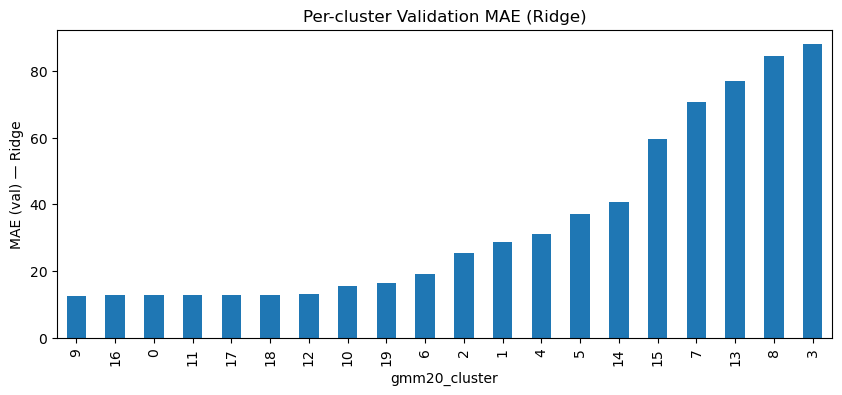

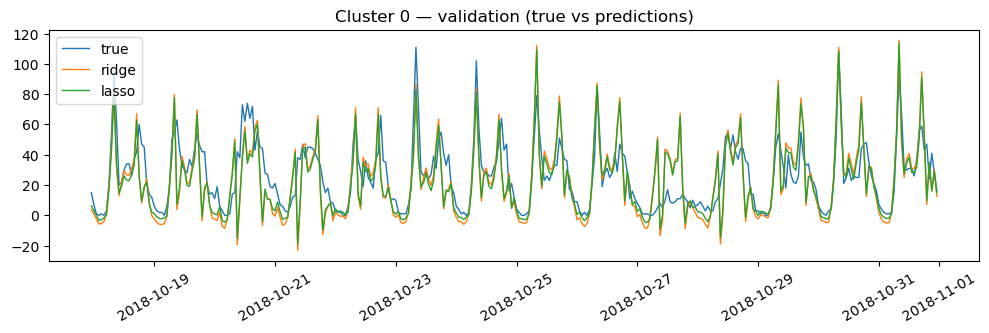

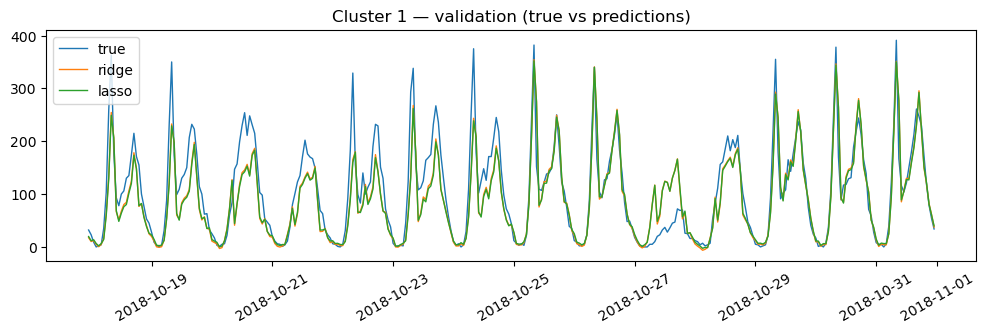

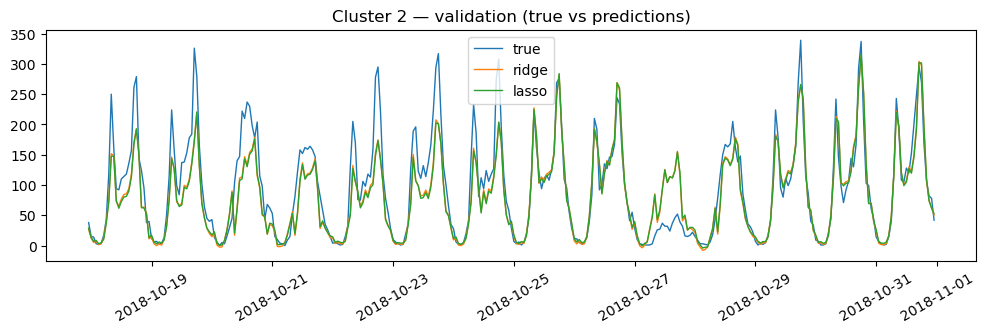

In [7]:

# Global MAE table
results = {
    'baseline_val_MAE': mean_absolute_error(val_b['y'].values, val_b['pred_naive'].values),
    'ridge_val_MAE': mean_absolute_error(val['y'].values, pred_val_ridge),
    'lasso_val_MAE': mean_absolute_error(val['y'].values, pred_val_lasso),
    'baseline_test_MAE': mean_absolute_error(test_b['y'].values, test_b['pred_naive'].values),
    'ridge_test_MAE': mean_absolute_error(test['y'].values, pred_test_ridge),
    'lasso_test_MAE': mean_absolute_error(test['y'].values, pred_test_lasso)
}
print(results)

# Per-cluster MAE (val) for Ridge
val_tmp = val.copy()
val_tmp['pred_ridge'] = pred_val_ridge
val_tmp['pred_lasso'] = pred_val_lasso

mae_cluster = val_tmp.groupby('gmm20_cluster').apply(lambda g: mean_absolute_error(g['y'], g['pred_ridge']))
mae_cluster = mae_cluster.sort_values()

plt.figure(figsize=(10,4))
mae_cluster.plot(kind='bar')
plt.ylabel("MAE (val) — Ridge")
plt.title("Per-cluster Validation MAE (Ridge)")
plt.show()

# Time-series example: pick 3 clusters to visualise
sample_clusters = list(val_tmp['gmm20_cluster'].unique()[:3])  # adjust indices if you want specific clusters
for c in sample_clusters:
    s = val_tmp[val_tmp['gmm20_cluster']==c].sort_values('timestamp').reset_index(drop=True)
    plt.figure(figsize=(12,3))
    plt.plot(s['timestamp'], s['y'], label='true', lw=1)
    plt.plot(s['timestamp'], s['pred_ridge'], label='ridge', lw=1)
    plt.plot(s['timestamp'], s['pred_lasso'], label='lasso', lw=1)
    plt.title(f"Cluster {c} — validation (true vs predictions)")
    plt.legend()
    plt.xticks(rotation=30)
    plt.show()




## Plots Drop-offs: global comparison, per-cluster MAE, and sample time series

{'baseline_val_MAE_drop': 23.476754015215555, 'ridge_val_MAE_drop': 33.08082523934857, 'lasso_val_MAE_drop': 32.95472270735714, 'baseline_test_MAE_drop': 29.837854866207103, 'ridge_test_MAE_drop': 24.044711489355493, 'lasso_test_MAE_drop': 23.274294706471398}


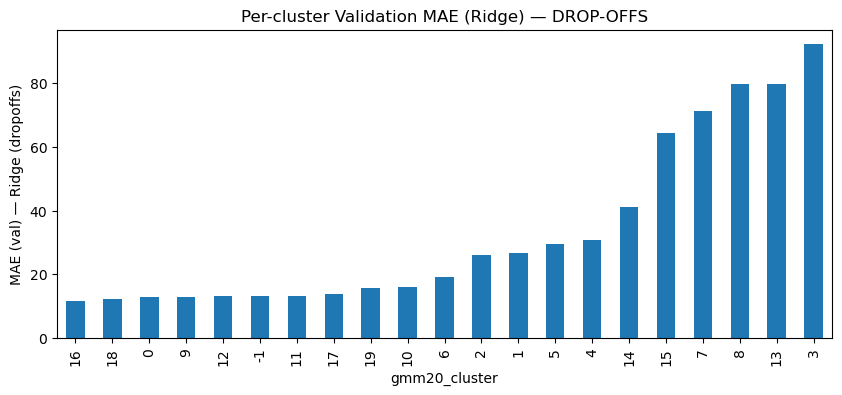

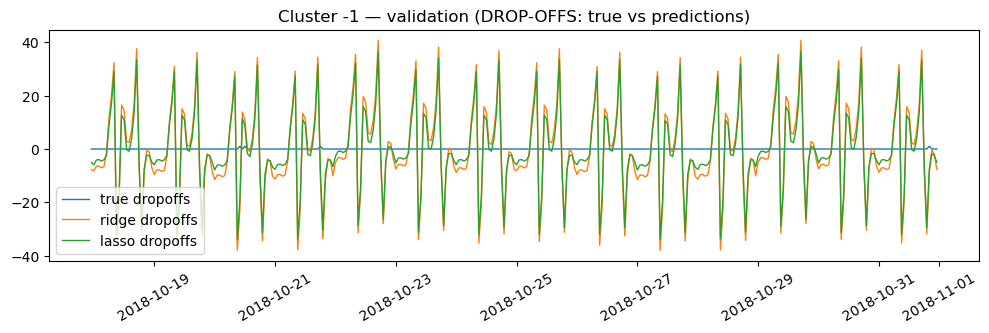

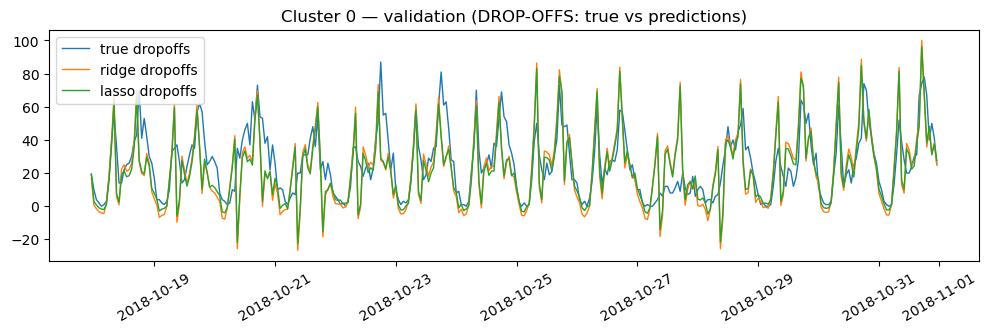

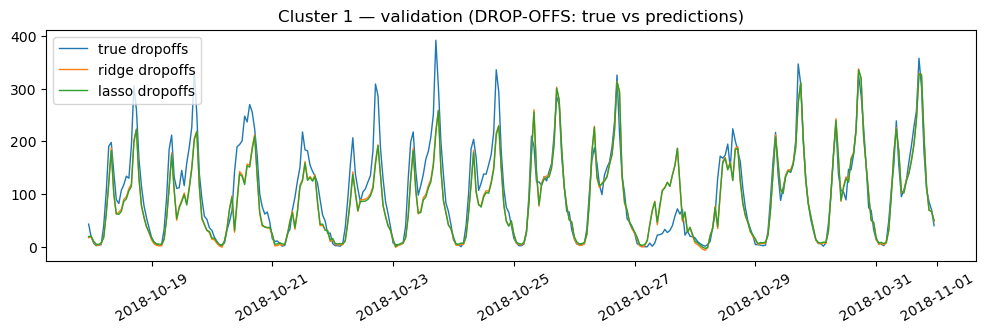

In [8]:

results_drop = {
    'baseline_val_MAE_drop': mean_absolute_error(val_bd['y'].values, val_bd['pred_naive'].values),
    'ridge_val_MAE_drop': mean_absolute_error(y_val_d, pred_val_ridge_d),
    'lasso_val_MAE_drop': mean_absolute_error(y_val_d, pred_val_lasso_d),
    'baseline_test_MAE_drop': mean_absolute_error(test_bd['y'].values, test_bd['pred_naive'].values),
    'ridge_test_MAE_drop': mean_absolute_error(y_test_d, pred_test_ridge_d),
    'lasso_test_MAE_drop': mean_absolute_error(y_test_d, pred_test_lasso_d)
}
print(results_drop)

# ================================
# DROP-OFFS: Per-cluster MAE (val) for Ridge
# ================================
val_tmp_d = val_d.copy()
val_tmp_d['pred_ridge'] = pred_val_ridge_d
val_tmp_d['pred_lasso'] = pred_val_lasso_d

mae_cluster_drop = val_tmp_d.groupby('gmm20_cluster').apply(
    lambda g: mean_absolute_error(g['y'], g['pred_ridge'])
)
mae_cluster_drop = mae_cluster_drop.sort_values()

plt.figure(figsize=(10,4))
mae_cluster_drop.plot(kind='bar')
plt.ylabel("MAE (val) — Ridge (dropoffs)")
plt.title("Per-cluster Validation MAE (Ridge) — DROP-OFFS")
plt.show()

# ================================
# DROP-OFFS: Time-series example
# ================================
sample_clusters_d = list(val_tmp_d['gmm20_cluster'].unique()[:3])

for c in sample_clusters_d:
    s = val_tmp_d[val_tmp_d['gmm20_cluster'] == c].sort_values('timestamp').reset_index(drop=True)
    plt.figure(figsize=(12,3))
    plt.plot(s['timestamp'], s['y'], label='true dropoffs', lw=1)
    plt.plot(s['timestamp'], s['pred_ridge'], label='ridge dropoffs', lw=1)
    plt.plot(s['timestamp'], s['pred_lasso'], label='lasso dropoffs', lw=1)
    plt.title(f"Cluster {c} — validation (DROP-OFFS: true vs predictions)")
    plt.legend()
    plt.xticks(rotation=30)
    plt.show()

## Improved Model: One Ridge Regressor per Cluster for Pick-Ups


Using global best alpha for per-cluster Ridge: 10.0
Fitting per-cluster Ridge for cluster 0 (train size = 6791)...
Fitting per-cluster Ridge for cluster 1 (train size = 6791)...
Fitting per-cluster Ridge for cluster 2 (train size = 6791)...
Fitting per-cluster Ridge for cluster 3 (train size = 6791)...
Fitting per-cluster Ridge for cluster 4 (train size = 6791)...
Fitting per-cluster Ridge for cluster 5 (train size = 6791)...
Fitting per-cluster Ridge for cluster 6 (train size = 6791)...
Fitting per-cluster Ridge for cluster 7 (train size = 6791)...
Fitting per-cluster Ridge for cluster 8 (train size = 6791)...
Fitting per-cluster Ridge for cluster 9 (train size = 6791)...
Fitting per-cluster Ridge for cluster 10 (train size = 6791)...
Fitting per-cluster Ridge for cluster 11 (train size = 6790)...
Fitting per-cluster Ridge for cluster 12 (train size = 6790)...
Fitting per-cluster Ridge for cluster 13 (train size = 6791)...
Fitting per-cluster Ridge for cluster 14 (train size = 6791)..

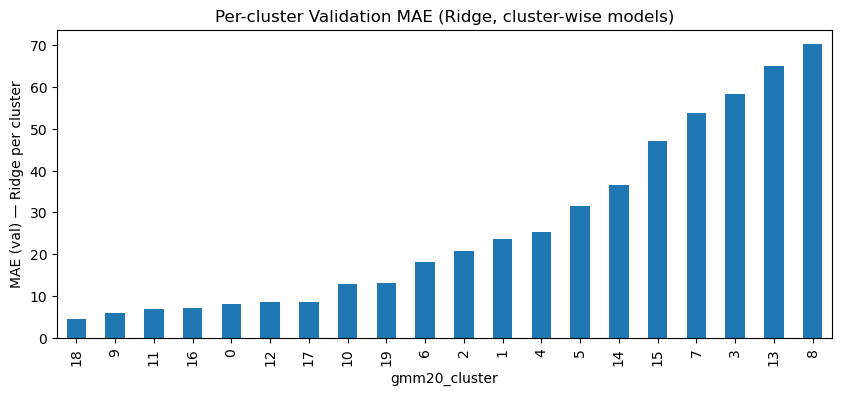

In [9]:
from sklearn.base import clone
from sklearn.linear_model import Ridge

# Same alpha 
best_alpha = best_ridge.named_steps['model'].alpha
print("Using global best alpha for per-cluster Ridge:", best_alpha)


num_feats = ['lag_1','lag_24','lag_168','rmean_3h','rmean_24h']
cat_feats = ['hour','weekday','gmm20_cluster']

cluster_models = {}
val_preds_cluster = []
test_preds_cluster = []

for c in sorted(train['gmm20_cluster'].unique()):
    # Filter de clusters
    train_c = train[train['gmm20_cluster'] == c].copy()
    val_c   = val[val['gmm20_cluster'] == c].copy()
    test_c  = test[test['gmm20_cluster'] == c].copy()

    
    if len(train_c) < 200:
        print(f"Skipping cluster {c} (too few train samples: {len(train_c)})")
        continue

    X_train_c = train_c[num_feats + cat_feats]
    y_train_c = train_c['y'].values
    X_val_c   = val_c[num_feats + cat_feats]
    y_val_c   = val_c['y'].values
    X_test_c  = test_c[num_feats + cat_feats]
    y_test_c  = test_c['y'].values

    # New pipeline per cluster 
    ridge_pipe_c = Pipeline([
        ('pre', clone(preproc)),
        ('to_dense', DenseTransformer()),
        ('model', Ridge(alpha=best_alpha))
    ])

    print(f"Fitting per-cluster Ridge for cluster {c} (train size = {len(train_c)})...")
    ridge_pipe_c.fit(X_train_c, y_train_c)

    # Save Model
    cluster_models[c] = ridge_pipe_c

    # Predictions val/test 
    val_pred_c = ridge_pipe_c.predict(X_val_c)
    test_pred_c = ridge_pipe_c.predict(X_test_c)

    # Save cluster & timestamp 
    val_preds_cluster.append(
        pd.DataFrame({
            'gmm20_cluster': c,
            'timestamp': val_c['timestamp'].values,
            'y': y_val_c,
            'y_pred_cluster_ridge': val_pred_c
        })
    )

    test_preds_cluster.append(
        pd.DataFrame({
            'gmm20_cluster': c,
            'timestamp': test_c['timestamp'].values,
            'y': y_test_c,
            'y_pred_cluster_ridge': test_pred_c
        })
    )

# Juntamos todas las predicciones de todos los clusters
val_cluster_df = pd.concat(val_preds_cluster, ignore_index=True)
test_cluster_df = pd.concat(test_preds_cluster, ignore_index=True)

# Ordenamos para compararlo con tu val/test original
val_cluster_df = val_cluster_df.sort_values(['gmm20_cluster','timestamp']).reset_index(drop=True)
test_cluster_df = test_cluster_df.sort_values(['gmm20_cluster','timestamp']).reset_index(drop=True)

val_sorted = val.sort_values(['gmm20_cluster','timestamp']).reset_index(drop=True)
test_sorted = test.sort_values(['gmm20_cluster','timestamp']).reset_index(drop=True)

# MAE global con modelo por cluster
mae_val_global_cluster = mean_absolute_error(val_sorted['y'], val_cluster_df['y_pred_cluster_ridge'])
mae_test_global_cluster = mean_absolute_error(test_sorted['y'], test_cluster_df['y_pred_cluster_ridge'])

print("\n=== Global MAE comparison (Ridge) ===")
print("Global Ridge VAL MAE:     ", mean_absolute_error(val['y'], pred_val_ridge))
print("Per-cluster Ridge VAL MAE:", mae_val_global_cluster)

print("Global Ridge TEST MAE:     ", mean_absolute_error(test['y'], pred_test_ridge))
print("Per-cluster Ridge TEST MAE:", mae_test_global_cluster)

# MAE por cluster (validation) para el modelo por cluster
mae_cluster_ridge_pc = val_cluster_df.groupby('gmm20_cluster').apply(
    lambda g: mean_absolute_error(g['y'], g['y_pred_cluster_ridge'])
).sort_values()

plt.figure(figsize=(10,4))
mae_cluster_ridge_pc.plot(kind='bar')
plt.ylabel("MAE (val) — Ridge per cluster")
plt.title("Per-cluster Validation MAE (Ridge, cluster-wise models)")
plt.show()


## Improved Model: One Ridge Regressor per Cluster for Drop-offs

Using global best alpha for per-cluster Ridge (DROP-OFFS): 10.0
[DROP-OFFS] Fitting per-cluster Ridge for cluster -1 (train size = 6581)...
[DROP-OFFS] Fitting per-cluster Ridge for cluster 0 (train size = 6791)...
[DROP-OFFS] Fitting per-cluster Ridge for cluster 1 (train size = 6791)...
[DROP-OFFS] Fitting per-cluster Ridge for cluster 2 (train size = 6791)...
[DROP-OFFS] Fitting per-cluster Ridge for cluster 3 (train size = 6791)...
[DROP-OFFS] Fitting per-cluster Ridge for cluster 4 (train size = 6791)...
[DROP-OFFS] Fitting per-cluster Ridge for cluster 5 (train size = 6791)...
[DROP-OFFS] Fitting per-cluster Ridge for cluster 6 (train size = 6791)...
[DROP-OFFS] Fitting per-cluster Ridge for cluster 7 (train size = 6791)...
[DROP-OFFS] Fitting per-cluster Ridge for cluster 8 (train size = 6791)...
[DROP-OFFS] Fitting per-cluster Ridge for cluster 9 (train size = 6790)...
[DROP-OFFS] Fitting per-cluster Ridge for cluster 10 (train size = 6791)...
[DROP-OFFS] Fitting per-cluster Ri

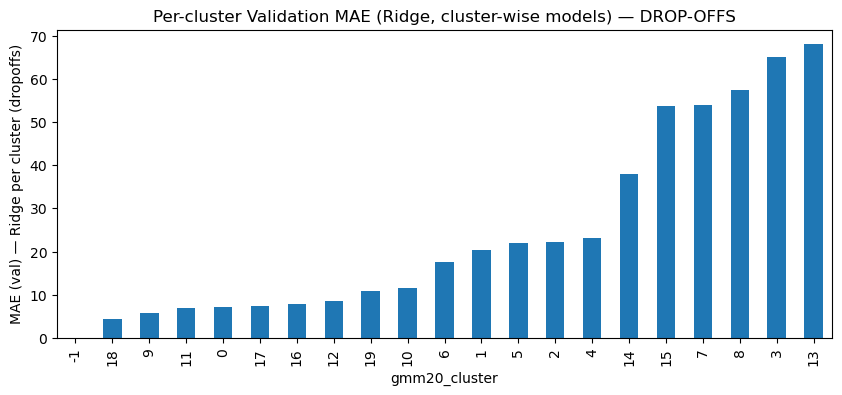

In [10]:
from sklearn.base import clone
from sklearn.linear_model import Ridge

# same alpha as best global dropoffs Ridge
best_alpha_d = best_ridge_d.named_steps['model'].alpha
print("Using global best alpha for per-cluster Ridge (DROP-OFFS):", best_alpha_d)

num_feats = ['lag_1','lag_24','lag_168','rmean_3h','rmean_24h']
cat_feats = ['hour','weekday','gmm20_cluster']

cluster_models_drop = {}
val_preds_cluster_d = []
test_preds_cluster_d = []

for c in sorted(train_d['gmm20_cluster'].unique()):
    train_dc = train_d[train_d['gmm20_cluster'] == c].copy()
    val_dc   = val_d[val_d['gmm20_cluster'] == c].copy()
    test_dc  = test_d[test_d['gmm20_cluster'] == c].copy()

    if len(train_dc) < 200:
        print(f"[DROP-OFFS] Skipping cluster {c} (too few train samples: {len(train_dc)})")
        continue

    X_train_dc = train_dc[num_feats + cat_feats]
    y_train_dc = train_dc['y'].values
    X_val_dc   = val_dc[num_feats + cat_feats]
    y_val_dc   = val_dc['y'].values
    X_test_dc  = test_dc[num_feats + cat_feats]
    y_test_dc  = test_dc['y'].values

    ridge_pipe_dc = Pipeline([
        ('pre', clone(preproc)),
        ('to_dense', DenseTransformer()),
        ('model', Ridge(alpha=best_alpha_d))
    ])

    print(f"[DROP-OFFS] Fitting per-cluster Ridge for cluster {c} (train size = {len(train_dc)})...")
    ridge_pipe_dc.fit(X_train_dc, y_train_dc)

    cluster_models_drop[c] = ridge_pipe_dc

    val_pred_dc = ridge_pipe_dc.predict(X_val_dc)
    test_pred_dc = ridge_pipe_dc.predict(X_test_dc)

    val_preds_cluster_d.append(
        pd.DataFrame({
            'gmm20_cluster': c,
            'timestamp': val_dc['timestamp'].values,
            'y': y_val_dc,
            'y_pred_cluster_ridge_drop': val_pred_dc
        })
    )

    test_preds_cluster_d.append(
        pd.DataFrame({
            'gmm20_cluster': c,
            'timestamp': test_dc['timestamp'].values,
            'y': y_test_dc,
            'y_pred_cluster_ridge_drop': test_pred_dc
        })
    )

val_cluster_df_d = pd.concat(val_preds_cluster_d, ignore_index=True)
test_cluster_df_d = pd.concat(test_preds_cluster_d, ignore_index=True)

val_cluster_df_d = val_cluster_df_d.sort_values(['gmm20_cluster','timestamp']).reset_index(drop=True)
test_cluster_df_d = test_cluster_df_d.sort_values(['gmm20_cluster','timestamp']).reset_index(drop=True)

val_sorted_d = val_d.sort_values(['gmm20_cluster','timestamp']).reset_index(drop=True)
test_sorted_d = test_d.sort_values(['gmm20_cluster','timestamp']).reset_index(drop=True)

mae_val_global_cluster_d = mean_absolute_error(val_sorted_d['y'], val_cluster_df_d['y_pred_cluster_ridge_drop'])
mae_test_global_cluster_d = mean_absolute_error(test_sorted_d['y'], test_cluster_df_d['y_pred_cluster_ridge_drop'])

print("\n=== Global MAE comparison (Ridge) — DROP-OFFS ===")
print("Global Ridge VAL MAE (dropoffs):     ", mean_absolute_error(y_val_d, pred_val_ridge_d))
print("Per-cluster Ridge VAL MAE (dropoffs):", mae_val_global_cluster_d)

print("Global Ridge TEST MAE (dropoffs):     ", mean_absolute_error(y_test_d, pred_test_ridge_d))
print("Per-cluster Ridge TEST MAE (dropoffs):", mae_test_global_cluster_d)

# MAE por cluster (val) para dropoffs per-cluster
mae_cluster_ridge_pc_d = val_cluster_df_d.groupby('gmm20_cluster').apply(
    lambda g: mean_absolute_error(g['y'], g['y_pred_cluster_ridge_drop'])
).sort_values()

plt.figure(figsize=(10,4))
mae_cluster_ridge_pc_d.plot(kind='bar')
plt.ylabel("MAE (val) — Ridge per cluster (dropoffs)")
plt.title("Per-cluster Validation MAE (Ridge, cluster-wise models) — DROP-OFFS")
plt.show()

## Task3: Bike repositioning usingpredicted pick-ups and drop-offs

Predictions for Task 3 (TEST period): (29274, 5)
Required bikes table shape: (1220, 4)
Example date: 2018-11-01
Required bikes per cluster on 2018-11-01


,gmm20_cluster,date,min_cumulative_balance,required_initial_bikes
488,8,2018-11-01,-855.971622,855.971622
305,5,2018-11-01,-579.965961,579.965961
915,15,2018-11-01,-222.645701,222.645701
61,1,2018-11-01,-198.640513,198.640513
244,4,2018-11-01,-190.329991,190.329991
793,13,2018-11-01,-167.428841,167.428841
1159,19,2018-11-01,-153.158261,153.158261
122,2,2018-11-01,-120.734134,120.734134
610,10,2018-11-01,-117.130605,117.130605
1037,17,2018-11-01,-114.053510,114.053510


Example cluster: 8


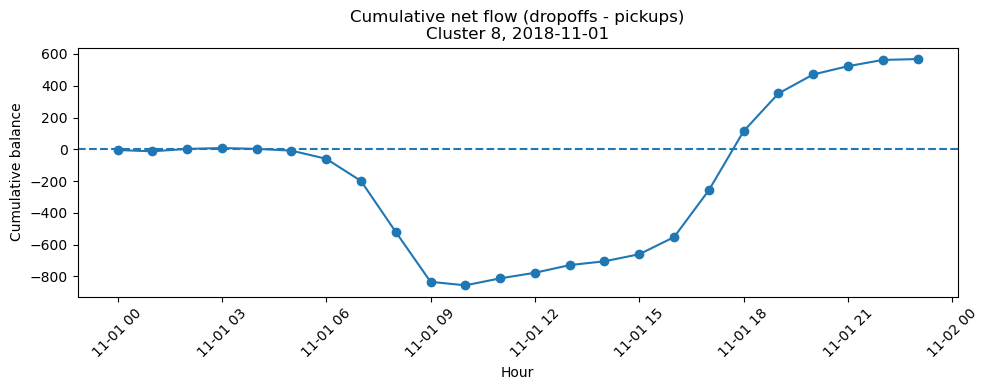

Minimum cumulative balance for cluster 8 on 2018-11-01: -855.971622146152


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# 1) Prepare a single table with predicted pickups and dropoffs
#    for the TEST period (Nov–Dec) and all clusters

# From previous blocks we already have:
# - test_cluster_df      → per-cluster Ridge predictions for pick-ups
# - test_cluster_df_d    → per-cluster Ridge predictions for drop-offs

# Rename prediction columns to be explicit
pick_test_pred = test_cluster_df.rename(
    columns={'y_pred_cluster_ridge': 'pred_pickups'}
)[['gmm20_cluster', 'timestamp', 'pred_pickups']]

drop_test_pred = test_cluster_df_d.rename(
    columns={'y_pred_cluster_ridge_drop': 'pred_dropoffs'}
)[['gmm20_cluster', 'timestamp', 'pred_dropoffs']]

# Merge pick-ups and drop-offs predictions on (cluster, timestamp)
pred_test = pick_test_pred.merge(
    drop_test_pred,
    on=['gmm20_cluster', 'timestamp'],
    how='inner'
)

# Add date column (day granularity)
pred_test['timestamp'] = pd.to_datetime(pred_test['timestamp'])
pred_test['date'] = pred_test['timestamp'].dt.date

# Sort for safety
pred_test = pred_test.sort_values(
    ['gmm20_cluster', 'timestamp']
).reset_index(drop=True)

print("Predictions for Task 3 (TEST period):", pred_test.shape)
pred_test.head()

# ---------------------------------------------------------
# 2) Function to compute required bikes for each cluster & day
# ---------------------------------------------------------

def compute_required_bikes_per_day(df):
    """
    Given a DataFrame with columns:
      - gmm20_cluster
      - timestamp
      - date
      - pred_pickups
      - pred_dropoffs

    For each (cluster, date), we compute:
      net(h)      = pred_dropoffs(h) - pred_pickups(h)
      cum_net(h)  = cumulative sum of net(h) over the day
      min_cum_net = minimum value of cum_net(h)

    The required initial bikes is:
      required_bikes = max(0, -min_cum_net)

    Intuition:
      - If cum_net never goes below 0 → no shortage → 0 bikes needed.
      - If cum_net reaches -35 at worst → we need at least 35 bikes
        at the beginning of the day to avoid running out of bikes.
    """
    results = []

    for (cluster, date), g in df.groupby(['gmm20_cluster', 'date']):
        # Sort by time within the day
        g = g.sort_values('timestamp').copy()

        # Net flow per hour (arrivals - departures)
        g['net'] = g['pred_dropoffs'] - g['pred_pickups']

        # Cumulative net flow over the day
        g['cum_net'] = g['net'].cumsum()

        # Minimum cumulative value (worst deficit)
        min_cum = g['cum_net'].min()

        # Bikes required so that the stock never goes below 0
        required_bikes = max(0, -min_cum)

        results.append({
            'gmm20_cluster': cluster,
            'date': date,
            'min_cumulative_balance': float(min_cum),
            'required_initial_bikes': float(required_bikes)
        })

    return pd.DataFrame(results)


required_bikes_df = compute_required_bikes_per_day(pred_test)
print("Required bikes table shape:", required_bikes_df.shape)
required_bikes_df.head()

# ---------------------------------------------------------
# 3) Example: show required bikes for a few clusters on one day
# ---------------------------------------------------------

# Pick an example day in the TEST period (e.g. the first day)
example_date = required_bikes_df['date'].min()
print("Example date:", example_date)

example_day = required_bikes_df[required_bikes_df['date'] == example_date]
print("Required bikes per cluster on", example_date)
display(example_day.sort_values('required_initial_bikes', ascending=False).head(10))

# ---------------------------------------------------------
# 4) Optional: visualize cumulative balance for one cluster and one day
# ---------------------------------------------------------

example_cluster = int(example_day.sort_values('required_initial_bikes',
                                              ascending=False).iloc[0]['gmm20_cluster'])
print("Example cluster:", example_cluster)

g_plot = pred_test[
    (pred_test['gmm20_cluster'] == example_cluster) &
    (pred_test['date'] == example_date)
].sort_values('timestamp').copy()

g_plot['net'] = g_plot['pred_dropoffs'] - g_plot['pred_pickups']
g_plot['cum_net'] = g_plot['net'].cumsum()

plt.figure(figsize=(10,4))
plt.plot(g_plot['timestamp'], g_plot['cum_net'], marker='o')
plt.axhline(0, linestyle='--')
plt.title(f"Cumulative net flow (dropoffs - pickups)\nCluster {example_cluster}, {example_date}")
plt.xlabel("Hour")
plt.ylabel("Cumulative balance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Minimum cumulative balance for cluster {example_cluster} on {example_date}:",
      g_plot['cum_net'].min())